In [1]:
import torch
import torch_geometric.transforms as T
import torch.nn as nn

from tqdm import tqdm
from torch.optim import Adam
from torch.nn import functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import VGAE, GraphConv
from torch.utils.tensorboard import SummaryWriter

In [2]:
dataset = Planetoid(root='./data', name='Cora', transform=T.NormalizeFeatures())
data = dataset[0]
data.train_mask = data.val_mask = data.test_mask = None
data = train_test_split_edges(data)

C:\Users\giang\.conda\envs\pygeo\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [4]:
print(data)

Data(x=[2708, 1433], y=[2708], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])


In [6]:
epochs = 300
lr = 0.01
hidden1 = 32
hidden2 = 16
dropout = 0

input_channels = data.num_node_features
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(input_channels, device)

1433 cpu


In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, dropout):
        super(Encoder, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden1)
        self.conv_mu = GraphConv(hidden1, hidden2)
        self.conv_logstd = GraphConv(hidden1, hidden2)
        self.dropout = dropout
        self.edge_index = None

    def conv_layer(self, x, conv):
        x = F.dropout(x, p=self.dropout, training=self.training)
        hidden = conv(x, self.edge_index)
        hidden = F.relu(hidden, True)
        return hidden

    def forward(self, x, edge_index):
        self.edge_index = edge_index
        hidden1 = self.conv_layer(x, self.conv1)
        return self.conv_mu(hidden1, edge_index), self.conv_logstd(hidden1, edge_index)


In [8]:
encoder = Encoder(input_channels, hidden1, hidden2, dropout)
model = VGAE(encoder).to(device)
optimizer = Adam(model.parameters(), lr)

In [18]:
print(model)

VGAE(
  (encoder): Encoder(
    (conv1): GraphConv(1433, 32)
    (conv_mu): GraphConv(32, 16)
    (conv_logstd): GraphConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)


In [25]:
print(data.y)

tensor([3, 4, 4,  ..., 3, 3, 3])


In [9]:
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

In [10]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index) + model.kl_loss() / data.num_nodes
    loss.backward()
    optimizer.step()
    return loss.item()

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
        return model.test(z, pos_edge_index, neg_edge_index)

In [11]:
writer = SummaryWriter('runs/VGAE_experiment_'+'300 epochs')

In [12]:
for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    if epoch % 100 == 0:
        print('Epoch: {:03d}, Loss: {:.4f}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, loss, auc, ap))
        writer.add_scalar('loss', loss, epoch)
        writer.add_scalar('auc', auc, epoch)
        writer.add_scalar('ap', ap, epoch)
    #print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')
    #writer.add_scalar('auc train',auc,epoch)
    #writer.add_scalar('ap train',ap,epoch)

Epoch: 100, Loss: 0.9153, AUC: 0.8784, AP: 0.8895
Epoch: 200, Loss: 0.8696, AUC: 0.8833, AP: 0.8966
Epoch: 300, Loss: 0.8419, AUC: 0.8963, AP: 0.9122


In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model.encode(x, train_pos_edge_index)
    z = TSNE(n_components=2, learning_rate="auto", init="pca").fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    fig = plt.figure(1, figsize=(8, 8))
    fig.clf()
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

C:\Users\giang\.conda\envs\pygeo\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


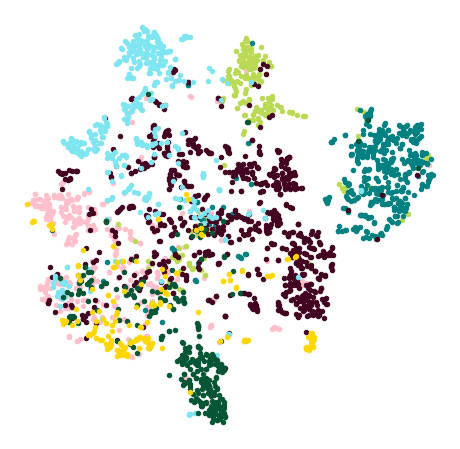

In [16]:
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)